In [1]:
import pandas as pd
sf = pd.read_csv('Airfoil_Self_Noise.csv')
sf.head()

,frequency,angle,length,velocity,thickness,pressure_level
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


In [2]:
sf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 6 columns):
frequency         1503 non-null int64
angle             1503 non-null float64
length            1503 non-null float64
velocity          1503 non-null float64
thickness         1503 non-null float64
pressure_level    1503 non-null float64
dtypes: float64(5), int64(1)
memory usage: 70.6 KB


In [3]:
sf.describe()

,frequency,angle,length,velocity,thickness,pressure_level
count,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000
mean,2886.380572,6.782302,0.136548,50.860745,0.011140,124.835943
std,3152.573137,5.918128,0.093541,15.572784,0.013150,6.898657
min,200.000000,0.000000,0.025400,31.700000,0.000401,103.380000
25%,800.000000,2.000000,0.050800,39.600000,0.002535,120.191000
50%,1600.000000,5.400000,0.101600,39.600000,0.004957,125.721000
75%,4000.000000,9.900000,0.228600,71.300000,0.015576,129.995500
max,20000.000000,22.200000,0.304800,71.300000,0.058411,140.987000


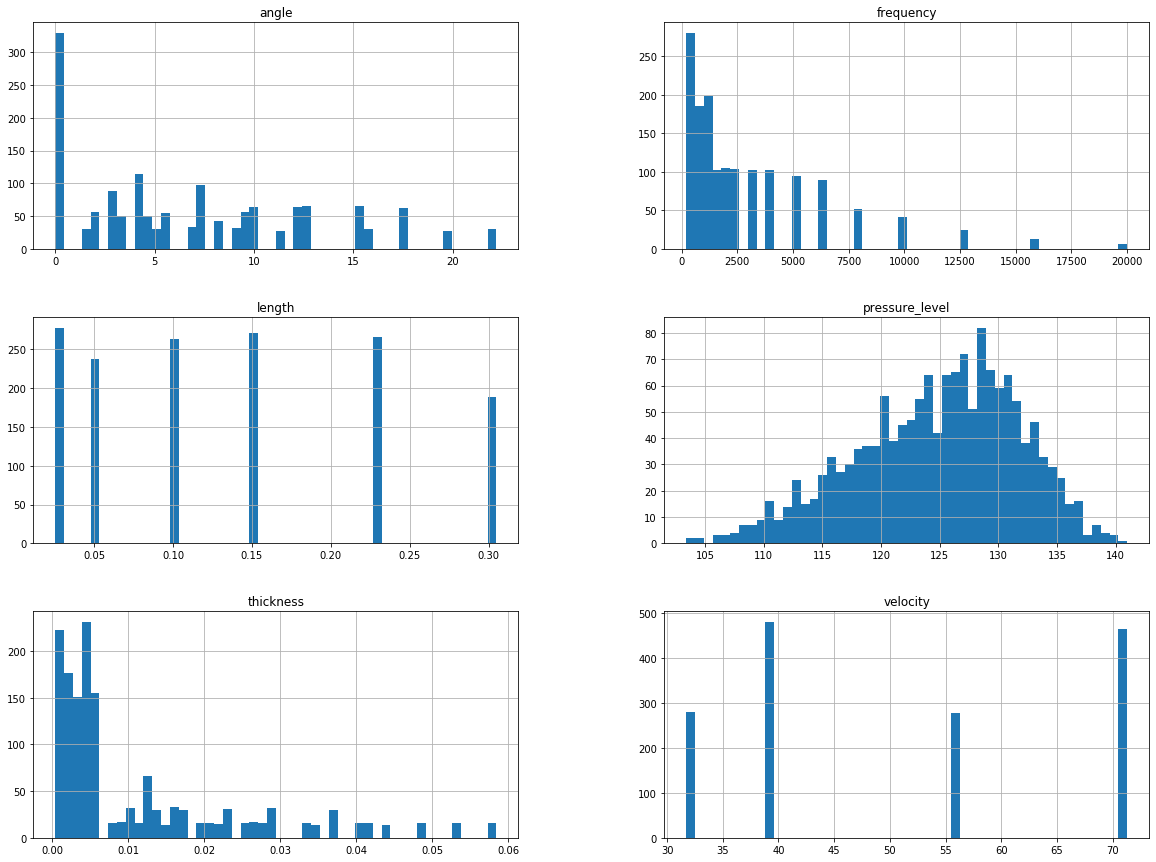

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
sf.hist(bins=50, figsize=(20,15))
plt.savefig("attribute_histogram_plots")
plt.show()

Observations: 

1. These variables have very different scales. We will discuss this later in this chapter when we explore feature scaling.

2. Many histograms are right skewed: they extend much farther to the right of the median than to the left. This may make it a bit harder for some Machine Learning algorithms to detect patterns. We will try transforming these attributes later on to have more bell-shaped distributions.

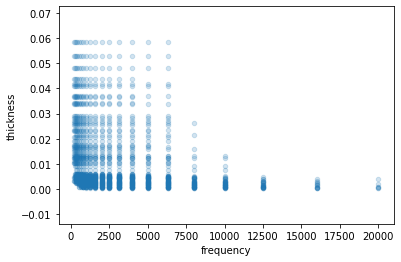

In [5]:
sf.plot(kind="scatter", x="frequency", y="thickness", alpha=0.2)
plt.savefig('map1.png')

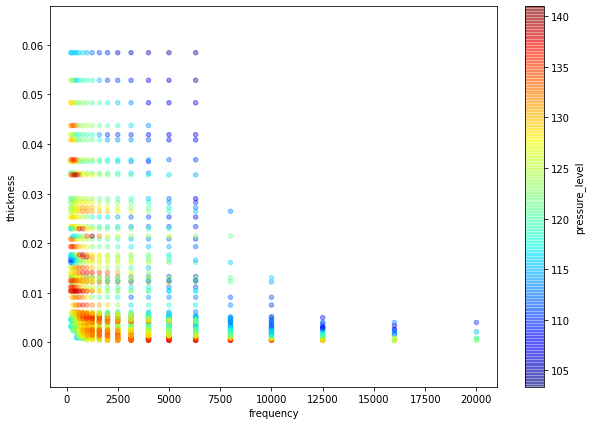

In [6]:
sf.plot(kind="scatter", x="frequency", y="thickness", alpha=0.4, figsize=(10,7),
    c="pressure_level", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.savefig('map2.png')

Now let’s look at how much each independent variable correlates with the pressure level.

In [7]:
corr_matrix = sf.corr()
corr_matrix["pressure_level"].sort_values(ascending=False)

pressure_level    1.000000
velocity          0.125103
angle            -0.156108
length           -0.236162
thickness        -0.312670
frequency        -0.390711
Name: pressure_level, dtype: float64

The pressure level tends to go up when the frequency, thickness, length and angle go down. You can see a small positive correlation between the velocity and the pressure level. 

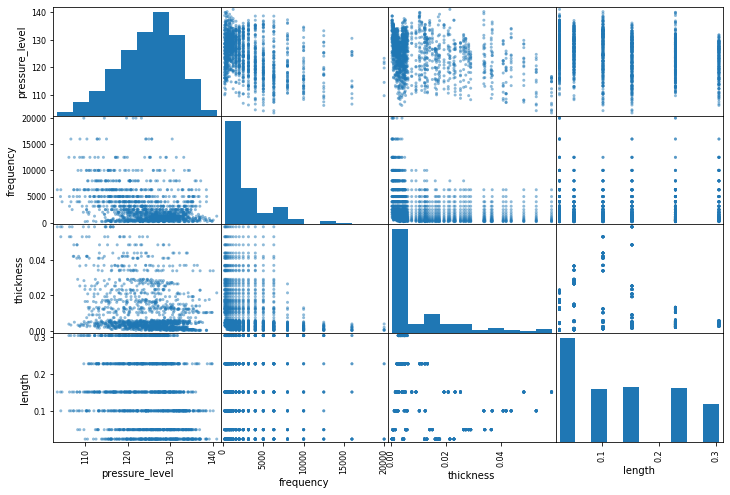

In [8]:
from pandas.plotting import scatter_matrix

attributes = ["pressure_level", "frequency", "thickness", "length"]
scatter_matrix(sf[attributes], figsize=(12, 8))
plt.savefig('matrix.png')

The most promising variable to predict the pressure level is the frequency, so let’s zoom in on their correlation scatterplot

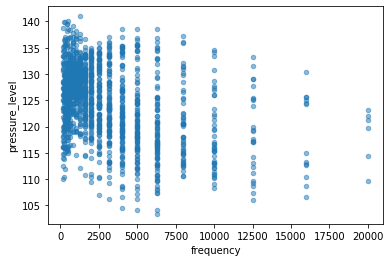

In [9]:
sf.plot(kind="scatter", x="frequency", y="pressure_level", alpha=0.5)
plt.savefig('scatter.png')

First, the correlation is not very strong; you can barely see the downward trend and the points are too dispersed.

In [10]:
X = sf[['frequency', 'angle', 'length', 'velocity']]
Y = sf['pressure_level']

In [11]:
X.shape 

(1503, 4)

In [12]:
Y.shape

(1503,)

Standardization of the data

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

In [15]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Done! We now have a working Linear Regression model.

In [16]:
y_pred = regressor.predict(X_test)
print('Liner Regression R squared: %.4f' % regressor.score(X_test, y_test))

Liner Regression R squared: 0.4967


So, in our model, 49.67% of the variability in Y can be explained using X. It is not so exciting.

Calculate root-mean-square error (RMSE)

In [17]:
import numpy as np
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(y_pred, y_test)
lin_rmse = np.sqrt(lin_mse)
print('Liner Regression RMSE: %.4f' % lin_rmse)

Liner Regression RMSE: 4.8645


Our model was able to predict the pressure level of every airfoil in the test set within 4.8645 decibel of the pressure level.

Calculate mean absolute error (MAE)

In [18]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(y_pred, y_test)
print('Liner Regression MAE: %.4f' % lin_mae)

Liner Regression MAE: 3.8166


let’s try a more complex model to see whether results can be improved - the RandomForestRegressor

In [19]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [20]:
print('Random Forest R squared": %.4f' % forest_reg.score(X_test, y_test))

Random Forest R squared": 0.9228


In [21]:
y_pred = forest_reg.predict(X_test)
forest_mse = mean_squared_error(y_pred, y_test)
forest_rmse = np.sqrt(forest_mse)
print('Random Forest RMSE: %.4f' % forest_rmse)

Random Forest RMSE: 1.9056


Much better! Let's try one more.

In [22]:
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor
model = ensemble.GradientBoostingRegressor()
model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [23]:
print('Gradient Boosting R squared": %.4f' % model.score(X_test, y_test))

Gradient Boosting R squared": 0.7995


In [24]:
y_pred = model.predict(X_test)
model_mse = mean_squared_error(y_pred, y_test)
model_rmse = np.sqrt(model_mse)
print('Gradient Boosting RMSE: %.4f' % model_rmse)

Gradient Boosting RMSE: 3.0707


I would consider the Random Forest Regressor as our final model, let's print out feature importance

In [25]:
feature_labels = np.array(['frequency', 'angle', 'length', 'velocity'])
importance = forest_reg.feature_importances_
feature_indexes_by_importance = importance.argsort()[::-1]
for index in feature_indexes_by_importance:
    print('{}-{:.2f}%'.format(feature_labels[index], (importance[index] *100.0)))

frequency-37.54%
length-29.15%
angle-26.36%
velocity-6.95%
